In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm.auto import tqdm
from skimage.metrics import peak_signal_noise_ratio
from IPython import display
import cv2
import matplotlib.pyplot as plt
from sr_model import FSRCNN

In [2]:
model = FSRCNN(2).cuda()
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

(1419, 1672, 3)
(709, 836, 3)
n_chunk_y:  5 n_chunk_x:  6


/tmp/ipykernel_1748/4064572971.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sr_img = np.empty((num_chunks_y*2*chunk_size, num_chunks_x*2*chunk_size, 3), dtype=np.float)


  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

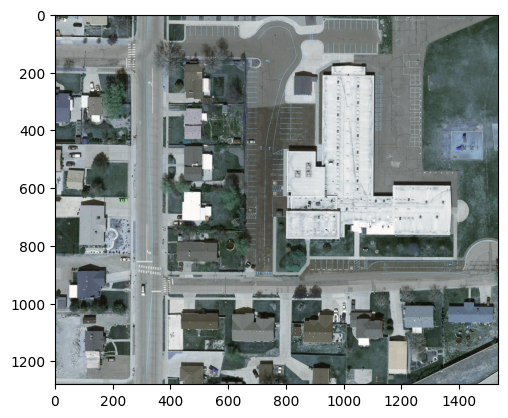

In [3]:
img = cv2.imread("urban_dataset_15cm/1.png")

print(img.shape)

blur_kernel = np.genfromtxt('PSF_E10x2.csv', delimiter=';')

blur_img = cv2.resize(cv2.filter2D(img, -1, blur_kernel), 
                      (img.shape[1]//2, img.shape[0]//2), 
                      interpolation = cv2.INTER_NEAREST)

plt.imshow(blur_img)

height, width, n_chan = blur_img.shape

print(blur_img.shape)

chunk_size = 128

num_chunks_y = height // chunk_size
num_chunks_x = width // chunk_size

print("n_chunk_y: ", num_chunks_y, "n_chunk_x: ", num_chunks_x)

sr_img = np.empty((num_chunks_y*2*chunk_size, num_chunks_x*2*chunk_size, 3), dtype=np.float)

to_tensor = transforms.ToTensor()

for i in tqdm(range(num_chunks_y)):
    for j in range(num_chunks_x):

        left = j * chunk_size    
        top = i * chunk_size
        right = left + chunk_size
        bottom = top + chunk_size
        
        blur_patch = to_tensor(blur_img[top:bottom, left:right])
        
        with torch.no_grad():
            y_hat = model(blur_patch.cuda().unsqueeze(0)).squeeze(0)
        
        sr_img[2*top:2*bottom, 2*left:2*right] = y_hat.permute(1,2,0).cpu().detach().numpy()
        
sr_img[sr_img>1] = 1
plt.imshow(sr_img)

sr_img = 255 * sr_img

cv2.imwrite("1_sr.png", sr_img)
cv2.imwrite("1_blur.png", blur_img)


2